### Кластеризация K-Means. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('data/clean.csv')
df.sample(3)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
546,1350,1,0.5,1,0,1,50,0.8,181,8,...,369,544,2287,15,1,8,1,1,0,1
1010,683,0,0.7,0,5,0,19,0.9,173,4,...,954,1985,2622,16,3,5,0,0,1,2
904,1062,0,1.5,0,3,0,45,0.2,151,3,...,798,1435,911,14,2,9,0,0,0,0


### Очистка и замена параметров.

In [4]:
# Оказалось, что в наборе данных существуют невозможные примеры
# (например, нулевая высота экрана). Удалим их.

# Любые параметры, кроме булевых, должны быть ненулевыми.
exclude = tuple(col for col in df.columns if set(df[col].unique()) <= {0, 1})

# Исключим потенциально нулевые признаки 
# (например, телефон может не иметь фронтальной камеры).
exclude += ('fc', 'pc', 'price_range')

# Очистка.
targets = [col for col in df.columns if col not in exclude]
print('Shape:', df.shape, end=' -> ')
df = df[(df[targets] != 0).all(axis=1)]
print(df.shape)
df[targets]

Shape: (2000, 21) -> (1819, 21)


,battery_power,clock_speed,int_memory,m_dep,mobile_wt,n_cores,px_height,px_width,ram,sc_h,sc_w,talk_time
0,842,2.2,7,0.6,188,2,20,756,2549,9,7,19
1,1021,0.5,53,0.7,136,3,905,1988,2631,17,3,7
2,563,0.5,41,0.9,145,5,1263,1716,2603,11,2,9
3,615,2.5,10,0.8,131,6,1216,1786,2769,16,8,11
4,1821,1.2,44,0.6,141,2,1208,1212,1411,8,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,0.5,2,0.8,106,6,1222,1890,668,13,4,19
1996,1965,2.6,39,0.2,187,4,915,1965,2032,11,10,16
1997,1911,0.9,36,0.7,108,8,868,1632,3057,9,1,5
1998,1512,0.9,46,0.1,145,5,336,670,869,18,10,19


In [5]:
# Заменим столбцы px_height и px_width на отношение сторон и общее число пикселей.
if 'px_height' in df.columns:
    pd.options.mode.chained_assignment = None
    df['aspect_ratio'] = df['px_width'] / df['px_height']
    df['resolution'] = df['px_height'] * df['px_width']
    print(df.sample(10, random_state=1)[['aspect_ratio', 'resolution', 'px_width', 'px_height']])
    # df = df.drop(['px_height', 'px_width'], axis=1)

      aspect_ratio  resolution  px_width  px_height
1985      1.317090     2795983      1919       1457
1072      1.652876     1623258      1638        991
558       1.295842     2788767      1901       1467
453       1.175163      687735       899        765
683       1.336077      710046       974        729
254       2.661952     1330574      1882        707
179       1.352308      571350       879        650
629       1.805732     1602342      1701        942
1518      2.567568     1550115      1995        777
1489      3.264493      994704      1802        552


### Кластеризация

D:\Development\job\university\fl-05-ml\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\Development\job\university\fl-05-ml\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


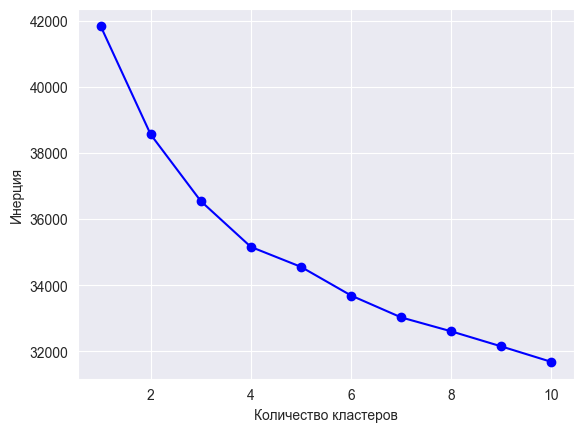

In [6]:
# Методом локтя определим количество кластеров. 
# Предположительно, оно должно быть небольшим.

# Масштабируем данные.
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Подбор числа кластеров.
inertia = []
sil_scores = []
k_range = range(1, 11)

for i in k_range:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Построим график инерции.
plt.plot(k_range, inertia, marker='o', color='blue')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.show()

In [7]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=0)
df['cluster'] = kmeans.fit_predict(df)
print(
    f'Distribution of df.{df["cluster"].value_counts()}\n'
    f'Number of runs: {kmeans.n_iter_}\n'
    f'Number of features: {kmeans.n_features_in_}\n'
    f'Inertia: {kmeans.inertia_}'
)

Distribution of df.cluster
1    913
3    436
0    308
2    162
Name: count, dtype: int64
Number of runs: 16
Number of features: 23
Inertia: 91537394720404.69


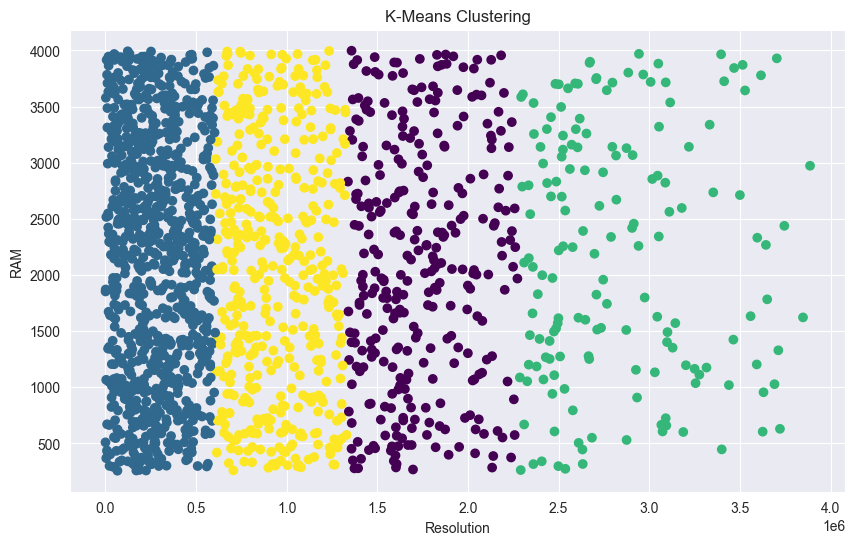

In [8]:
# Визуализация кластеров.
plt.figure(figsize=(10, 6))
plt.scatter(df['resolution'], df['ram'], c=df['cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Resolution')
plt.ylabel('RAM')
plt.show()

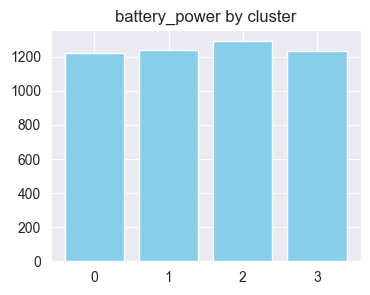

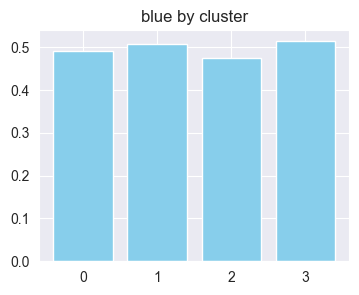

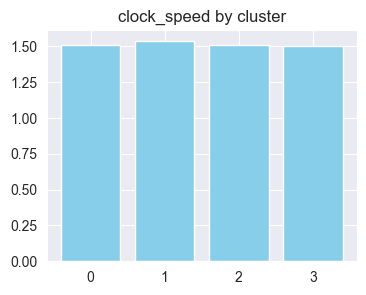

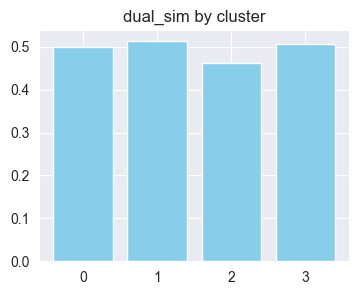

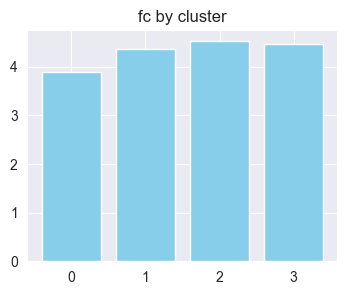

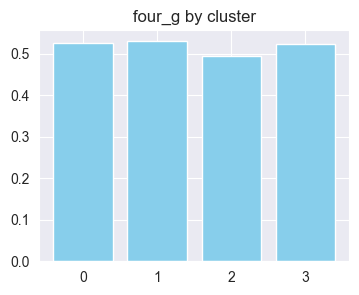

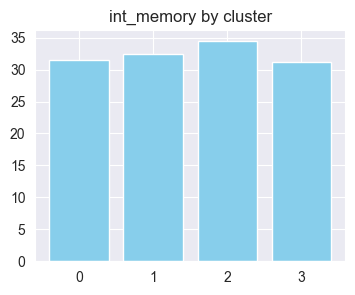

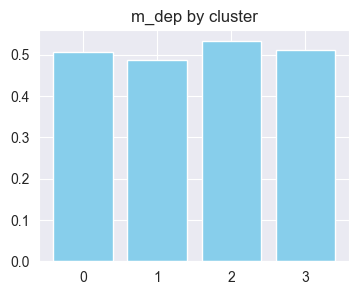

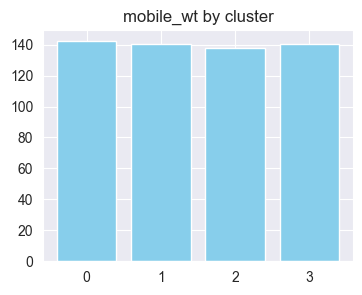

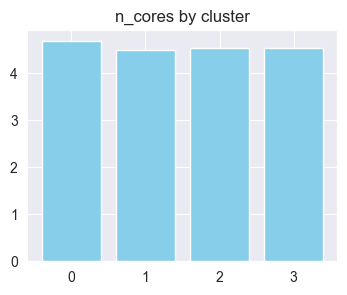

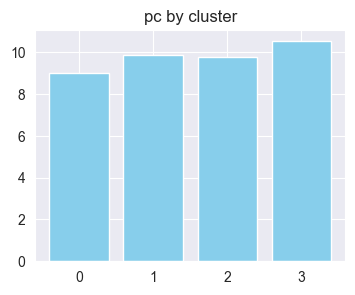

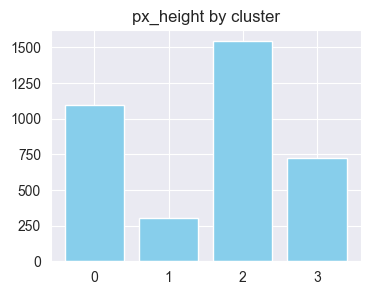

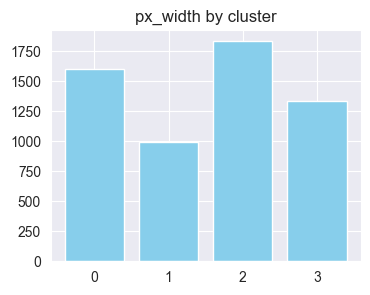

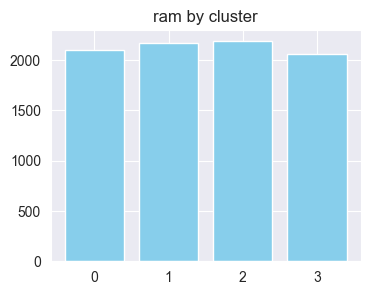

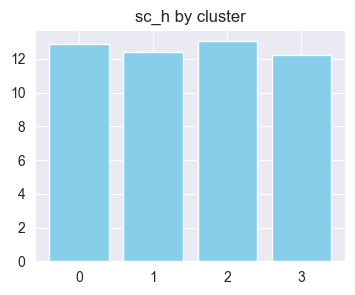

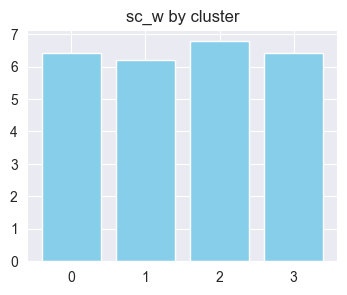

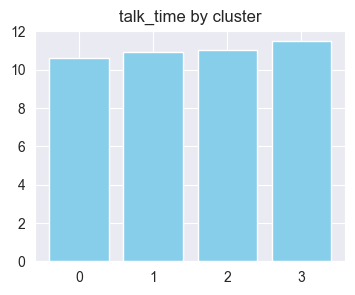

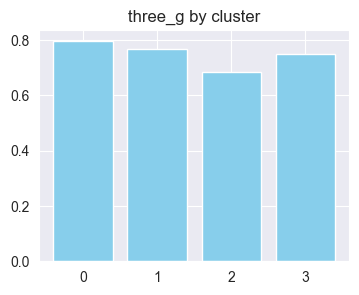

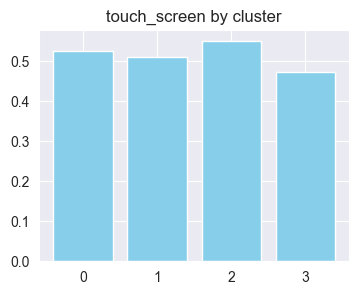

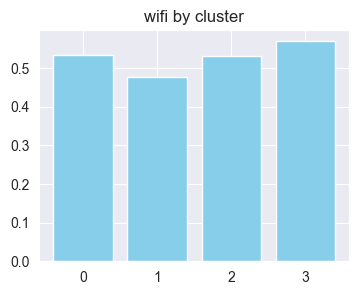

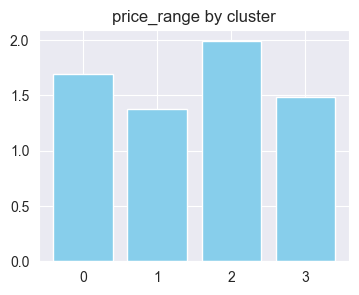

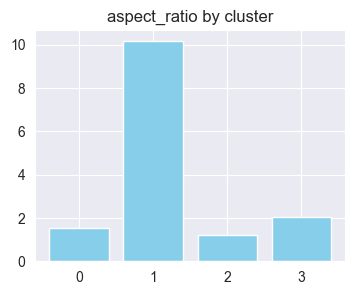

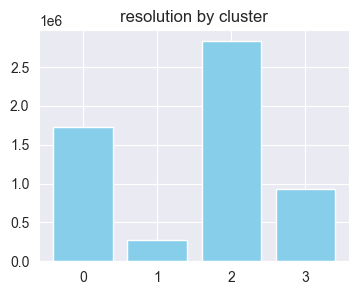

In [10]:
for col in df.columns:
    if col == 'cluster':
        continue
    means = df.groupby('cluster')[col].mean()
    plt.figure(figsize=(4, 3))     
    plt.bar(means.index, means.values, color='skyblue')
    plt.title(f'{col} by cluster')
    plt.show()